# CMRM Assignment No. 2

In [2]:
import os
import numpy as np
import soundfile as sf
import librosa
import sklearn # pip install sklearn
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm # pip install tqdm
from nmf import nmf

## Question 1

In [3]:
## Define directories and lists
output_dir = "audio/results"
source_dir = "audio/audio/sources"
target_dir = "audio/audio/targets"
sources = ["Bees_Buzzing.mp3", "Wind_Blowing.mp3", "Chainsaw_Sawing.mp3"]
targets = ["Jingle_Bells_Boogie.wav", "Have_Yourself.wav", "Blue_Christmas.wav", "White_Christmas.wav"]

## Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)


# Define the source and target variables using the respective lists
source = sources[0]  # Selecting "Bees Buzzing.wav" from the sources list
target = targets[0]  # Selecting "Jingle Bells Boogie.wav" from the targets list

In [4]:
## Load signals
Fs = 22050

# Load the source and target waveforms
source_path = os.path.join(source_dir, source)
target_path = os.path.join(target_dir, target)

# Load audio files
source_waveform, _ = librosa.load(source_path, sr=Fs, mono=True)
target_waveform, _ = librosa.load(target_path, sr=Fs, mono=True)

Dimension of source STFT :(2049, 1433)
Dimension of source STFT magnitude:(2049, 1433)
Dimension of target STFT :(2049, 1113)
Dimension of target STFT magnitude:(2049, 1113)
Time resolution: 0.046 seconds
Frequency resolution: 5.383 Hz


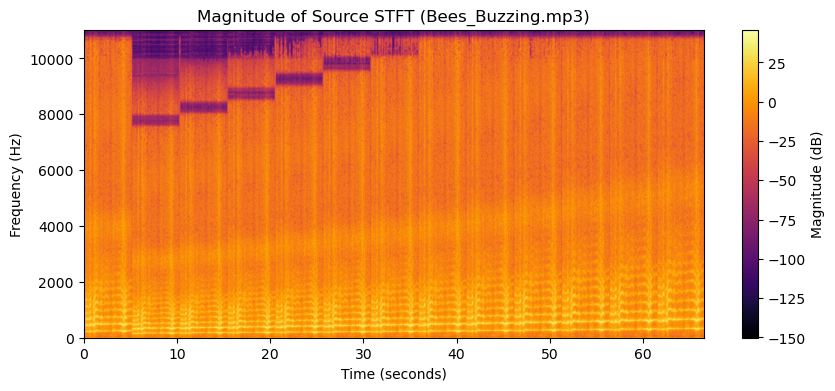

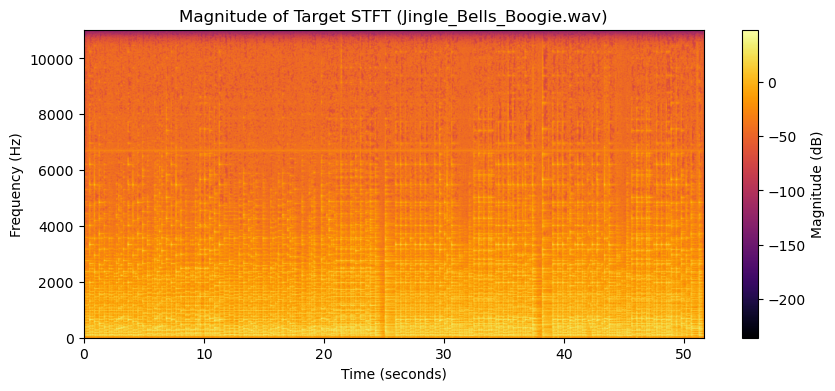

In [5]:
N_length = 4096  # Define the window length for the STFT 
H_size = 1024   # Define the hop size (distance between successive windows)

## STFT computation

## Source

X_source = librosa.stft(source_waveform, n_fft=N_length, hop_length=H_size)  # Compute the Short-Time Fourier Transform of the source waveform

Y_source = np.abs(X_source)  # Compute the magnitude (absolute value) of the complex source STFT

print(f"Dimension of source STFT :{X_source.shape}")  # Print the dimensions of the complex STFT
print(f"Dimension of source STFT magnitude:{Y_source.shape}")  # Print the dimensions of the magnitude STFT

## Plot

eps = np.finfo(float).eps  # Compute small epsilon to avoid log(0) issues
Y_source_db = 20 * np.log10(Y_source + eps)  # Convert magnitude to decibel scale for better visualization

time_axis = np.arange(X_source.shape[1]) / (Fs / H_size)  # Calculate the time axis in seconds 
frequency_axis = np.arange(X_source.shape[0]) / (N_length / Fs)  # Calculate the frequency axis in Hz 

x_ext = (time_axis[1] - time_axis[0]) / 2  # Half-frame adjustment for better centering on the time axis
y_ext = (frequency_axis[1] - frequency_axis[0]) / 2  # Half-bin adjustment for better centering on the frequency axis
image_extent = [time_axis[0] - x_ext, time_axis[-1] + x_ext, frequency_axis[0] - y_ext, frequency_axis[-1] + y_ext]  # Define the extent of the plot axes

plt.figure(figsize=(10, 4))  # Set the figure size
plt.title(f"Magnitude of Source STFT ({source})")  # Set the title of the plot
plt.imshow(Y_source_db, extent=image_extent, aspect='auto', origin='lower', cmap='inferno')  # Display the magnitude spectrogram in decibels
plt.colorbar(label='Magnitude (dB)')  # Add a colorbar with the label 'Magnitude (dB)'
plt.xlabel('Time (seconds)')  # Label for the x-axis
plt.ylabel('Frequency (Hz)')  # Label for the y-axis

## Target

X_target = librosa.stft(target_waveform, n_fft=N_length, hop_length=H_size)  

Y_target = np.abs(X_target) 

print(f"Dimension of target STFT :{X_target.shape}")  
print(f"Dimension of target STFT magnitude:{Y_target.shape}")  

## Plot

Y_target_db = 20 * np.log10(Y_target + eps)  

time_axis = np.arange(X_target.shape[1]) / (Fs / H_size)  
frequency_axis = np.arange(X_target.shape[0]) / (N_length / Fs) 

x_ext = (time_axis[1] - time_axis[0]) / 2  
y_ext = (frequency_axis[1] - frequency_axis[0]) / 2 
image_extent = [time_axis[0] - x_ext, time_axis[-1] + x_ext, frequency_axis[0] - y_ext, frequency_axis[-1] + y_ext]  
 
plt.figure(figsize=(10, 4))  
plt.title(f"Magnitude of Target STFT ({target})")  
plt.imshow(Y_target_db, extent=image_extent, aspect='auto', origin='lower', cmap='inferno')  
plt.colorbar(label='Magnitude (dB)')  
plt.xlabel('Time (seconds)') 
plt.ylabel('Frequency (Hz)') 

# Compute time resolution and frequency resolution
time_res = H_size / Fs  # Time resolution in seconds, calculated as hop size divided by sampling rate
freq_res = Fs / N_length  # Frequency resolution in Hz, calculated as sampling rate divided by window length 

print(f"Time resolution: {time_res:.3f} seconds")  # Output the time resolution 
print(f"Frequency resolution: {freq_res:.3f} Hz")  # Output the frequency resolution


## Question 2

In [6]:
## Initialize activations randomly

# Initialization of the activation matrix H0
np.random.seed(42)  # Set a random seed for reproducibility
H0 = np.random.rand(X_source.shape[1], X_target.shape[1])  # Initialize H0 with random values 
print(f"Dimension of activation matrix H0 (PxN): {H0.shape}")  # Print the dimensions of H0

## Initialize templates according to source frames

# Initialization of the template matrix W0
W0 = Y_source / (np.sum(Y_source, axis=0, keepdims=True) + eps) # Normalize Y_source along columns to create the template matrix W0 
print(f"Dimension of template matrix W0 (KxP): {W0.shape}")  # Print the dimensions of W0

# Definition of Xs (normalization of the source STFT)
Xs = X_source / (np.sum(Y_source, axis=0, keepdims=True) + eps) # Normalize X_source using the same column-wise normalization as W0
print(f"Dimension of the normalized source STFT Xs: {Xs.shape}")  # Print the dimensions of Xs

## NMF

# Execution of NMF using the provided function
W, H = nmf(
    V=Y_target,  # Input target magnitude STFT
    init_W=W0,  # Initial template matrix
    init_H=H0,  # Initial activation matrix
    num_iter=50,  # Number of iterations
    fix_W=True,  # Fix templates during optimization
    cont_polyphony=10,  # Control parameter for polyphony
    cont_length=7,  # Continuity length parameter
    cont_grid=5,  # Grid parameter for continuity
    cont_sparsen=(1, 7)  # Sparsity parameters
)
# Perform NMF to learn W and H

V_approx = np.dot(W, H)  # Compute the approximated magnitude STFT 
print(f"Dimension of magnitude STFT approximation (KxN): {V_approx.shape}")  # Print the dimensions of V_approx

## Error norm

error = np.linalg.norm(Y_target - V_approx, ord='fro') # Compute the Frobenius norm of the error (difference between true and approximated STFT)
print(f"Frobenius norm of the error between true and approximated magnitude STFTs: {error:.4f}")

norm_Y_target = np.linalg.norm(Y_target, ord='fro')  # Compute the Frobenius norm of the true magnitude STFT
print(f"Frobenius norm of true magnitude STFT: {norm_Y_target:.4f}")

normalized_error = error / norm_Y_target # Compute the normalized error as the ratio of the error to the norm of Y_target
print(f"Normalized error: {normalized_error:.3%}")




Dimension of activation matrix H0 (PxN): (1433, 1113)
Dimension of template matrix W0 (KxP): (2049, 1433)
Dimension of the normalized source STFT Xs: (2049, 1433)


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Dimension of magnitude STFT approximation (KxN): (2049, 1113)
Frobenius norm of the error between true and approximated magnitude STFTs: 5001.6865
Frobenius norm of true magnitude STFT: 6577.9336
Normalized error: 76.037%


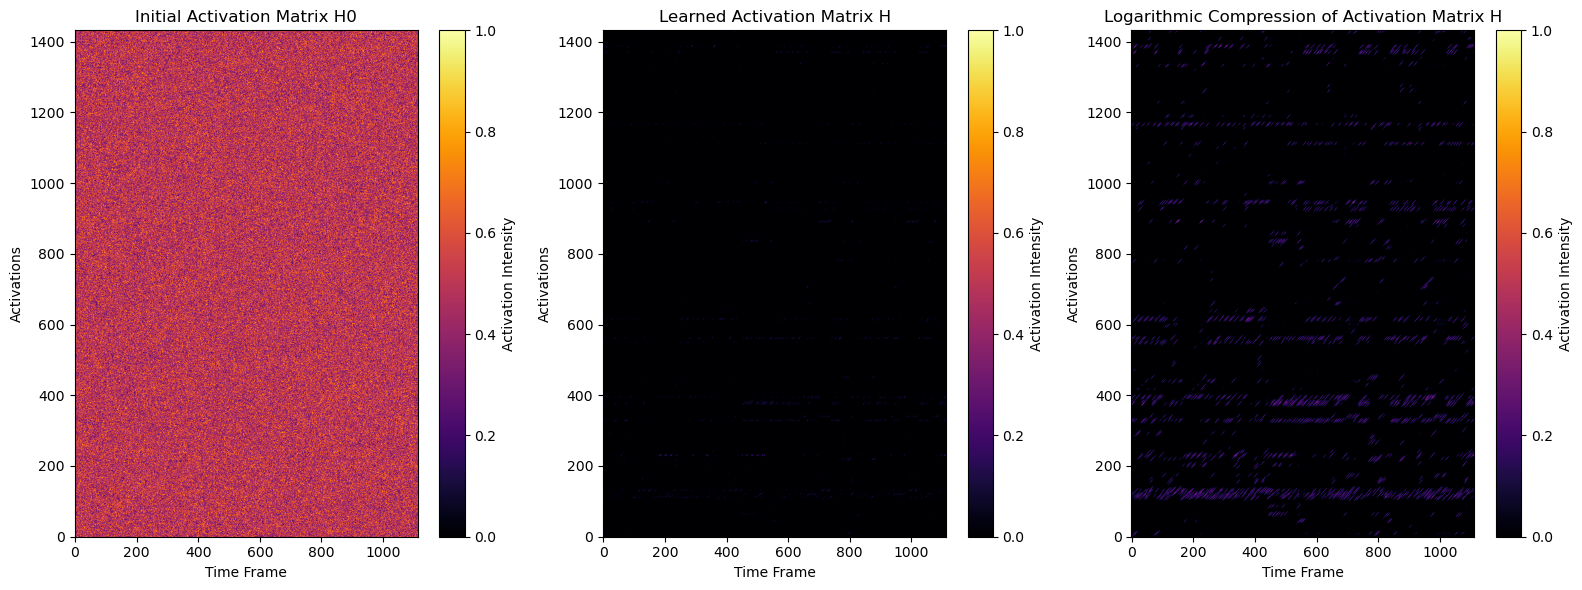

In [7]:
## Plot H0 and H 

def normalize(data, normalize=True):
    """Normalize a matrix to the range [0, 1]."""
    return (data - np.min(data)) / (np.max(data) - np.min(data) + np.finfo(float).eps) if normalize else data

plt.figure(figsize=(16, 6))  # Set the figure size to accommodate three plots

# Initial activation matrix H0
plt.subplot(1, 3, 1)  # Create the first subplot for H0
plt.title("Initial Activation Matrix H0")  # Set the title of the plot
plt.imshow(normalize(H0), aspect='auto', origin='lower', cmap='inferno')  # Visualize H0 with a colormap
plt.colorbar(label="Activation Intensity")  # Add a colorbar with a label
plt.xlabel("Time Frame")  # Label the x-axis as 'Time Frame'
plt.ylabel("Activations")  # Label the y-axis as 'Activations'

# Learned activation matrix H
plt.subplot(1, 3, 2)  
plt.title("Learned Activation Matrix H")  
plt.imshow(normalize(H), aspect='auto', origin='lower', cmap='inferno')  
plt.colorbar(label="Activation Intensity")
plt.xlabel("Time Frame") 
plt.ylabel("Activations")  

# Logarithmic Compression of Activation Matrix H
gamma_factor = 10  # Adjust the gamma factor for desired compression strength
H_log = np.log(1 + gamma_factor * H) # Apply logarithmic compression 
plt.subplot(1, 3, 3)  
plt.title("Logarithmic Compression of Activation Matrix H")
plt.imshow(normalize(H_log), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Activation Intensity")
plt.xlabel("Time Frame") 
plt.ylabel("Activations")  

plt.tight_layout()  # Adjust layout to avoid overlaps
plt.show()  # Display the plot


In [8]:
def visualize_nmf(V, W, H, fs, time_res, gamma=None):
    """Visualize the matrices W, H, and compare reconstruction V ~ WH to V

    Args:
        V: target magnitude STFT
        W: template matrix
        H: activation matrix
        fs: sampling frequency
        time_res: time resolution
        gamma: compression factor for matrices
        normalize: whether to normalize matrices to [0, 1]

    Returns:
        None
    """
    def apply_compression(data, gamma=gamma):
        """Applies logarithmic compression if gamma is provided."""
        return np.log(1 + gamma * data) if gamma is not None else data

    def normalize(data, normalize=True):
        """Normalize a matrix to the range [0, 1]."""
        return (data - np.min(data)) / (np.max(data) - np.min(data) + np.finfo(float).eps) if normalize else data

    # Compute approximation
    V_approx = np.dot(W, H)

    # Define frequency and time axes
    freq_res = fs / V.shape[0]  # Frequency resolution
    freq_axis = np.arange(V.shape[0]) * freq_res  # Frequency axis in Hz
    freq_limit = 2000  # Frequency limit for display
    freq_bins = np.sum(freq_axis <= freq_limit)  # Number of frequency bins up to the limit
    time_axis = np.arange(V.shape[1]) * time_res  # Time axis in seconds

    # Define extent for plots
    x_ext = time_res / 2  # Half-frame adjustment for centering on the time axis
    y_ext = freq_res / 2  # Half-bin adjustment for centering on the frequency axis

    plt.figure(figsize=(18, 12))  # Set the figure size

    # Plot Activation Matrix H
    extent_h = [time_axis[0] - x_ext, time_axis[-1] + x_ext, 0, H.shape[0]]
    plt.subplot(2, 2, 1)
    plt.title("Activation Matrix (H)")
    plt.imshow(normalize(apply_compression(H)), aspect='auto', origin='lower', extent=extent_h, cmap='inferno')
    plt.colorbar(label="Magnitude")
    plt.xlabel("Time (s)")
    plt.ylabel("Activations")

    # Plot Spectral Template Matrix W
    extent_w = [0, W.shape[1], freq_axis[0] - y_ext, freq_limit + y_ext]
    plt.subplot(2, 2, 2)
    plt.title("Template Matrix (W)")
    plt.imshow(normalize(apply_compression(W[:freq_bins, :])), aspect='auto', origin='lower', extent=extent_w, cmap='inferno')
    plt.colorbar(label="Magnitude")
    plt.xlabel("Templates")
    plt.ylabel("Frequency (Hz)")
    plt.ylim([0, freq_limit])

    # Plot Approximated Magnitude V_approx
    extent_v = [time_axis[0] - x_ext, time_axis[-1] + x_ext, freq_axis[0] - y_ext, freq_limit + y_ext]
    plt.subplot(2, 2, 3)
    plt.title("Approximated Magnitude")
    plt.imshow(normalize(apply_compression(V_approx[:freq_bins, :])), aspect='auto', origin='lower', extent=extent_v, cmap='inferno')
    plt.colorbar(label="Magnitude")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim([0, freq_limit])

    # Plot Target Magnitude Y_target
    plt.subplot(2, 2, 4)
    plt.title("Target Magnitude")
    plt.imshow(normalize(apply_compression(V[:freq_bins, :])), aspect='auto', origin='lower', extent=extent_v, cmap='inferno')
    plt.colorbar(label="Magnitude")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim([0, freq_limit])

    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plots

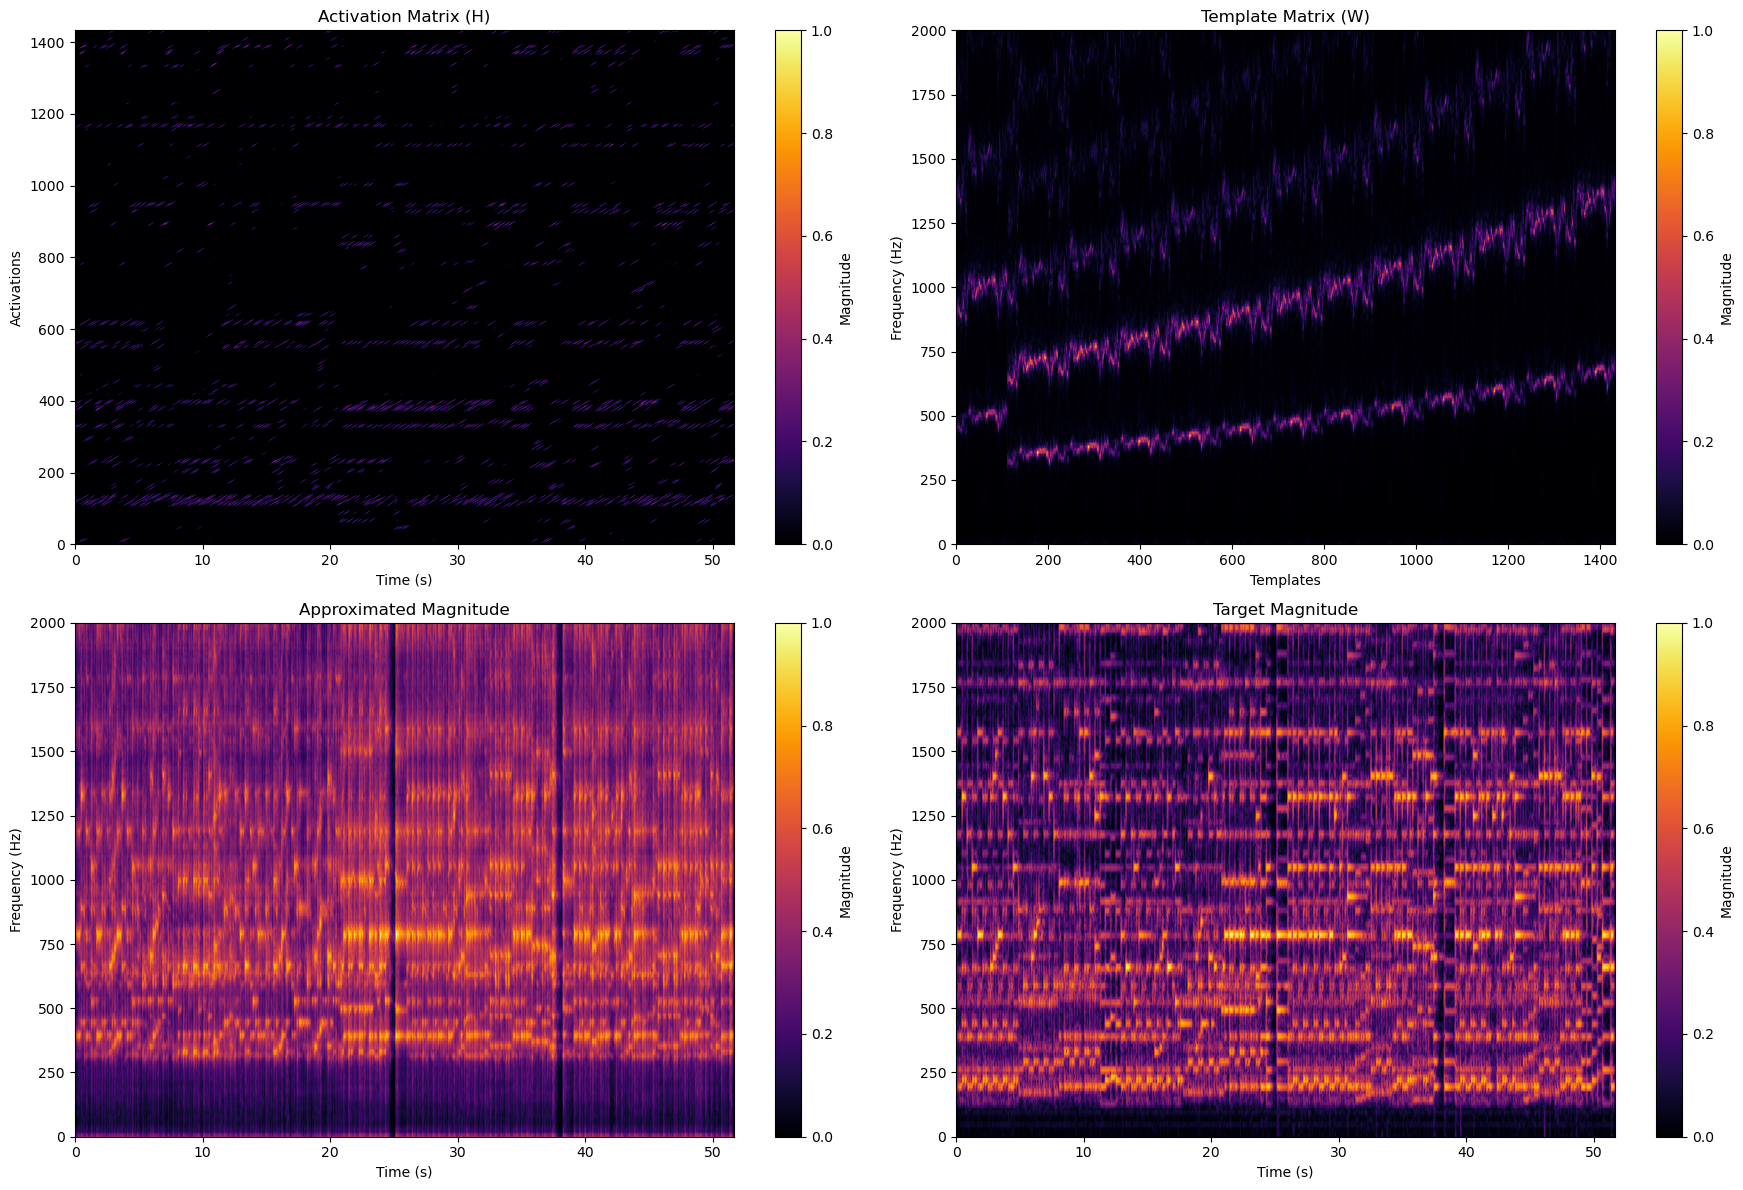

In [9]:
## Test visualize_nmfs
visualize_nmf(Y_target, W, H, Fs, time_res, gamma = 2)

## Question 3

In [ ]:
# Replace the magnitude frames by complex valued frames


# Re-synthesize using ISTFT


# Re-synthesize using Griffin-Lim algorithm



In [ ]:
# Save result


In [ ]:
# Phase check 
# ISTFT


# Griffin-Lim


In [ ]:
# Play target


In [ ]:
# Play source


In [ ]:
# Play new target - ISTFT


In [ ]:
# Play new target - GF


## Question 4

In [ ]:
# Define the function timbre_transfer
def timbre_transfer(t, s, fs, hop_size=1024, win_length=4096, resynth='gf', plot=False):
    """
    Transfer the timbre from the source to the target

    Args:
        t: target waveform
        s: source waveform
        fs: sampling frequency
        hop_size: hop size used for the STFT computation and the re-synthesis
        win_length: length of the window used for the STFT computation and the re-synthesis
        resynth: method used for the audio re-synthesis. Methods available: 'gf' = Griffin-Lim, 'istft' = Inverse STFT
        plot: boolean enabling visualization of NMF matrices and target spectrogram 

    Returns:
        y: audio waveform resynthesized through the chosen method
    """
    # 1. Compute the magnitude STFT of both the target and the source
    X_target = librosa.stft(t, n_fft=win_length, hop_length=hop_size)
    X_source = librosa.stft(s, n_fft=win_length, hop_length=hop_size)

    Y_target = np.abs(X_target)
    Y_source = np.abs(X_source)

    # 2. Initialize the activation matrix (H0)
    H0 = np.random.rand(X_source.shape[1], X_target.shape[1])

    # 3. Initialize the template matrix (W0)
    W0 = Y_source / (np.sum(Y_source, axis=0, keepdims=True) + np.finfo(float).eps)

    # 4. Normalize the STFT of the source
    Xs = X_source / (np.sum(Y_source, axis=0, keepdims=True) + np.finfo(float).eps)

    # 5. Perform nonnegative matrix factorization on the target magnitude STFT
    W, H = nmf(
        V=Y_target,
        init_W=W0,
        init_H=H0,
        num_iter=50,
        fix_W=True,
        cont_polyphony=10,
        cont_length=7,
        cont_grid=5,
        cont_sparsen=(1, 7)
    )
    # 6. Compute the complex-domain STFT of the processed track
    Y_tt = np.dot(Xs, H) 

    # 7. Visualization
    if plot:
        time_res = hop_size / fs
        visualize_nmf(Y_target, W0, H, fs, time_res) #################################################Ytarget or Ytt???

    # 8. Re-synthesize the audio
    if resynth == 'istft':
        y = librosa.istft(Y_tt, hop_length=hop_size, win_length=win_length)
    elif resynth == 'gf':
        y = librosa.griffinlim(np.abs(Y_tt), hop_length=hop_size, win_length=win_length)
    else:
        raise ValueError("Invalid re-synthesis method. Choose 'istft' or 'gf'.")

    # 9. Save the audio
    audio_filename = f"timbre_transfer_{resynth}.wav"
    sf.write(audio_filename, y, fs)

    # 10. Listen to the audio
    ipd.display(ipd.Audio(y, rate=fs))

    return y


## Question 5

In [ ]:
# Use the function timbre_tansfer for all the possible combinations of source and target

